# The center of the Sun in a partial eclipse image

The typical images of a partial solar eclipse are a bright orange disk (the Sun) covered partially by a black disk (the Moon). The two disks are about the same size. The result is an orange area enclosed by two arcs. 

To find the center of the sun, we first find the edge of the image using Canny edge finder. Then we randomly select 3 points from the edge pixels; as long as they do not fall in a straight line, they define a unique circle. We can find the center of the circle. This process is repeated and the statistics of the centers is collected. The coordinates of the real center of a large circle will most likely to be at the highest density point. In the case of eclipse, there should be two likely centers, one for the Sun and the other for the Moon. We choose the one closest to the center of gravity of the bright region.

Given three points on a circle, we can determine the center. Let $(x_i, y_i)$ be the $i$-th point on a circle, and the center of the circle be $(x_0, y_0)$. They satisfy the equations

$$
(x_i-x_0)^2 + (y_i-y_0)^2 = r^2.
$$

Subtracting the equation with $i=2$ from that with $i=1$, we have

$$
x_1^2 - x_2^2 + y_1^2 - y_2^2 - 2x_0(x_1-x_2) - 2y_0(y_1-y_2) = 0.
$$

Let $m_{ij} = (y_i-y_j)/(x_i-x_j)$, $\bar{x}_{ij} = (x_i+x_j)/2$, $\bar{y}_{ij} = (y_i+y_j)/2$, and use the fact $a^2-b^2 = (a+b)(a-b)$, and the above equation becomes

$$
x_0 + m_{ij} y_0 = \bar{x}_{ij} + m_{ij}\bar{y}_{ij}.
$$

Now we can solve $(x_0, y_0)$ using the equations

\begin{align}
x_0 + m_{12} y_0 &= \bar{x}_{12} + m_{12}\bar{y}_{12}, \\
x_0 + m_{13} y_0 &= \bar{x}_{13} + m_{13}\bar{y}_{13}
\end{align}

We arrive at

\begin{align}
x_0 &= \frac{m_{13}\bar{x}_{12} - m_{12}\bar{x}_{13} + m_{12}m_{13}(\bar{y}_{12}-\bar{y}_{13})} {m_{13}-m_{12}}\\
y_0 &= -\frac{\bar{x}_{12} - \bar{x}_{13} + m_{12}\bar{y}_{12}-m_{13}\bar{y}_{13}} {m_{13}-m_{12}}\\
\end{align}

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import io as skio

## Load the test image

The image is in a tiff format, converted by dcraw from the raw file of Sony A6000. The data format is 16-bit integer.

In [4]:
img = skio.imread('testimg.tiff')/(2**16-1)
print(img.dtype)

float64


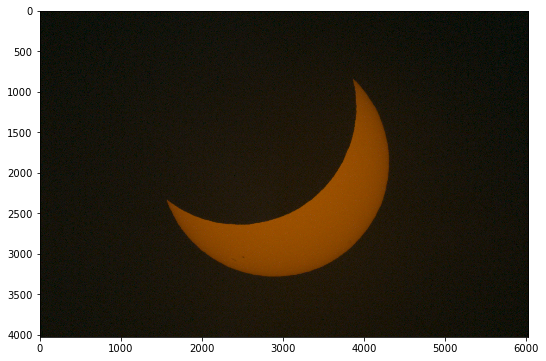

In [5]:
plt.figure(figsize=(9,6))
plt.imshow(img**0.45);

## Find the edge

Use sigma=3 to reduce noise. 

In [35]:
# Use the R channel only
edges3 = feature.canny(img[...,0]/img[...,0].max(), sigma=3)
print((edges3==True).sum())
print(edges3.shape)

10041
(4024, 6024)


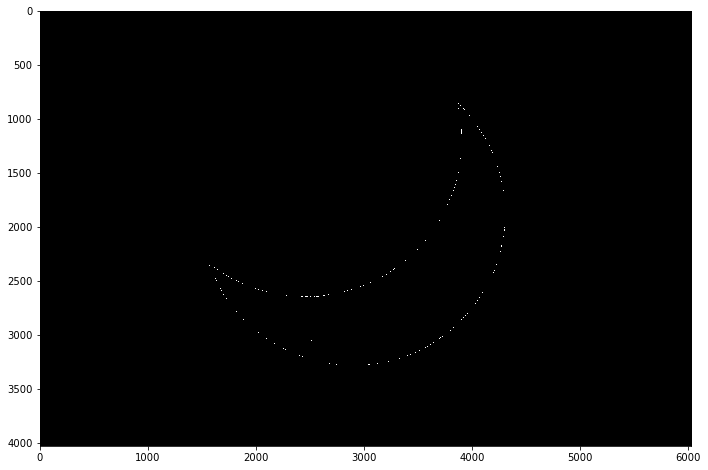

In [12]:
plt.figure(figsize=(12,8))
plt.imshow(edges3, cmap='gray');

## Find center statistics

In [87]:
def cxy3pt(xcoords, ycoords):
    '''
    Return the center coordinate as a 2-tuple in xy style. If the three points are in a line,
    return None.
    Parameters:
    -----------
    xcoords: 1d array-like of length 3
    ycoords: 1d array-like of length 3
    '''
    x1, x2, x3 = xcoords
    y1, y2, y3 = ycoords
    # Are they in a straight line?
    v12 = np.array([x1-x2, y1-y2])
    v13 = np.array([x1-x3, y1-y3])
    if np.abs(np.cross(v12, v13)) < 1e-12:
        return None, None

    if x1 == x2:
        # swap 1, 3
        x1, x3 = x3, x1
        y1, y3 = y3, y1
    elif x1 == x3:
        # swap 1, 2
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    x12 = (x1+x2)/2
    x13 = (x1+x3)/2
    y12 = (y1+y2)/2
    y13 = (y1+y3)/2
    m12 = (y1-y2)/(x1-x2)
    m13 = (y1-y3)/(x1-x3)

    x0 = (m13*x12 - m12*x13 + m12*m13*(y12-y13)) / (m13-m12)
    y0 = -(x12 - x13 + m12*y12 - m13*y13) / (m13-m12)
    
    return x0, y0

\begin{align}
x_0 &= \frac{m_{13}\bar{x}_{12} - m_{12}\bar{x}_{13} + m_{12}m_{13}(\bar{y}_{12}-\bar{y}_{13})} {m_{13}-m_{12}}\\
y_0 &= -\frac{\bar{x}_{12} - \bar{x}_{13} + m_{12}\bar{y}_{12}-m_{13}\bar{y}_{13}} {m_{13}-m_{12}}\\
\end{align}

In [88]:
# edges coordinates
eycoords, excoords = np.where(edges3)
print(len(excoords), len(eycoords))

10041 10041


In [89]:
# permutate the order
idx = np.random.permutation(len(excoords))
excoords = excoords[idx]
eycoords = eycoords[idx]

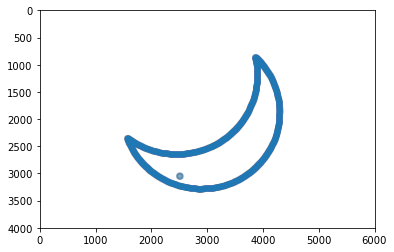

In [96]:
plt.scatter(excoords, eycoords, alpha=0.01);
plt.xlim(0, 6000);
plt.ylim(4000, 0);

In [90]:
centers = []
for i in range(0, len(idx)-3, 3):
    x0, y0 = cxy3pt(excoords[i:i+3], eycoords[i:i+3])
    centers.append((x0, y0))
centers = np.array(centers)

In [91]:
centers.shape

(3346, 2)

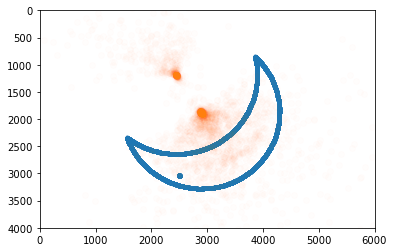

In [100]:
plt.scatter(excoords, eycoords, marker='.')
plt.scatter(centers[:,0], centers[:,1], alpha=0.01)
plt.xlim(0, 6000)
plt.ylim(4000,0);